<a href="https://colab.research.google.com/github/cychen116/DataAnalysis_practice/blob/main/09_EDA_ML_LinearRegresion_Pytorch_Dimonds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Grab the Diamond price dataset from Kaggle
https://www.kaggle.com/shivam2503/diamonds/data#__sid=js0

* Use multivariate linear model to see if you can predict diamoond price 
* Use dummy variables for categorical features -- get_dummies
* Determine optimal number of features to predict on
* Try to use polynomial features on at least one column
* Deliberately underfit / overfit thee data and see what happens

# Library Loading


In [ ]:
!pip install jovian

In [1]:
import torch
import numpy as np
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split 
from sklearn.preprocessing import OneHotEncoder

In [2]:
sns.set_style("darkgrid")

# Data Loading

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/EMSE 6575/Data"
!ls "/content/drive/MyDrive/Colab Notebooks/EMSE 6575/Data"

 archive.zip
'breast cancer.csv'
 breast_cancer_data.csv
'Breast Cancer Dignostics_google.ipynb'
'Breast Cancer Dignostics.ipynb'
 diamonds.csv
 gender_submission.csv
'Group Project 1 Text for Analysis -- full version(1).txt'
 HR_comma_sep.csv
 iris.csv
 spam.csv
 spam_resaved.xlsx
 spam.xlsx
 test.csv
 train.csv
 train-images-idx3-ubyte.gz
 train-labels-idx1-ubyte.gz


In [148]:
data = pd.read_csv(data_dir + '/diamonds.csv')
data.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)
print("data shape: " , data.shape)
data.head()

data shape:  (53940, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


# Exploratory Data Analysis (EDA)

##  Continuous Variables

In [109]:
# checking missing values and caculate the number
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [150]:
data['volume'] = data['x']*data['y']*data['z']

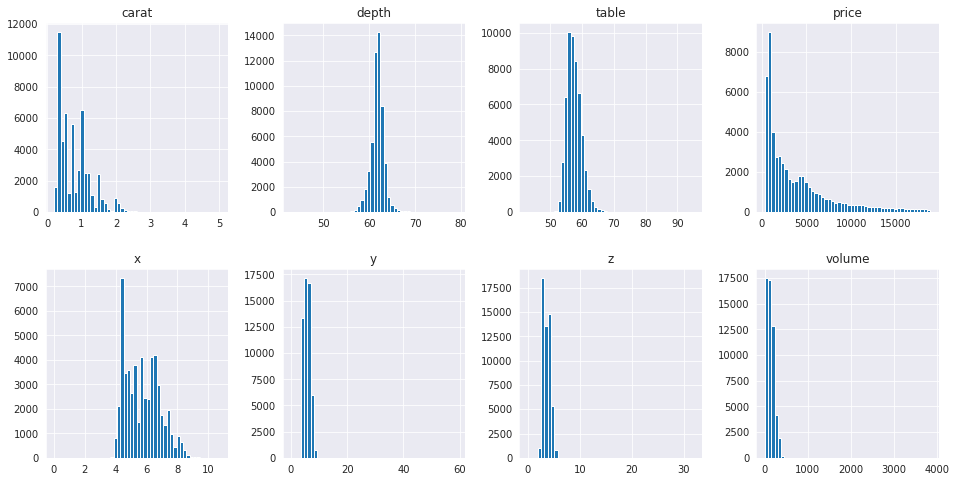

In [112]:
# Distributions for the continuous variables
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(16,8))
fig = data.hist(ax=axes, bins=50)
plt.show()

- **Carat** and **Price** is right skeweed. For further analysis, it is better to transform the data that close to normal distribution.

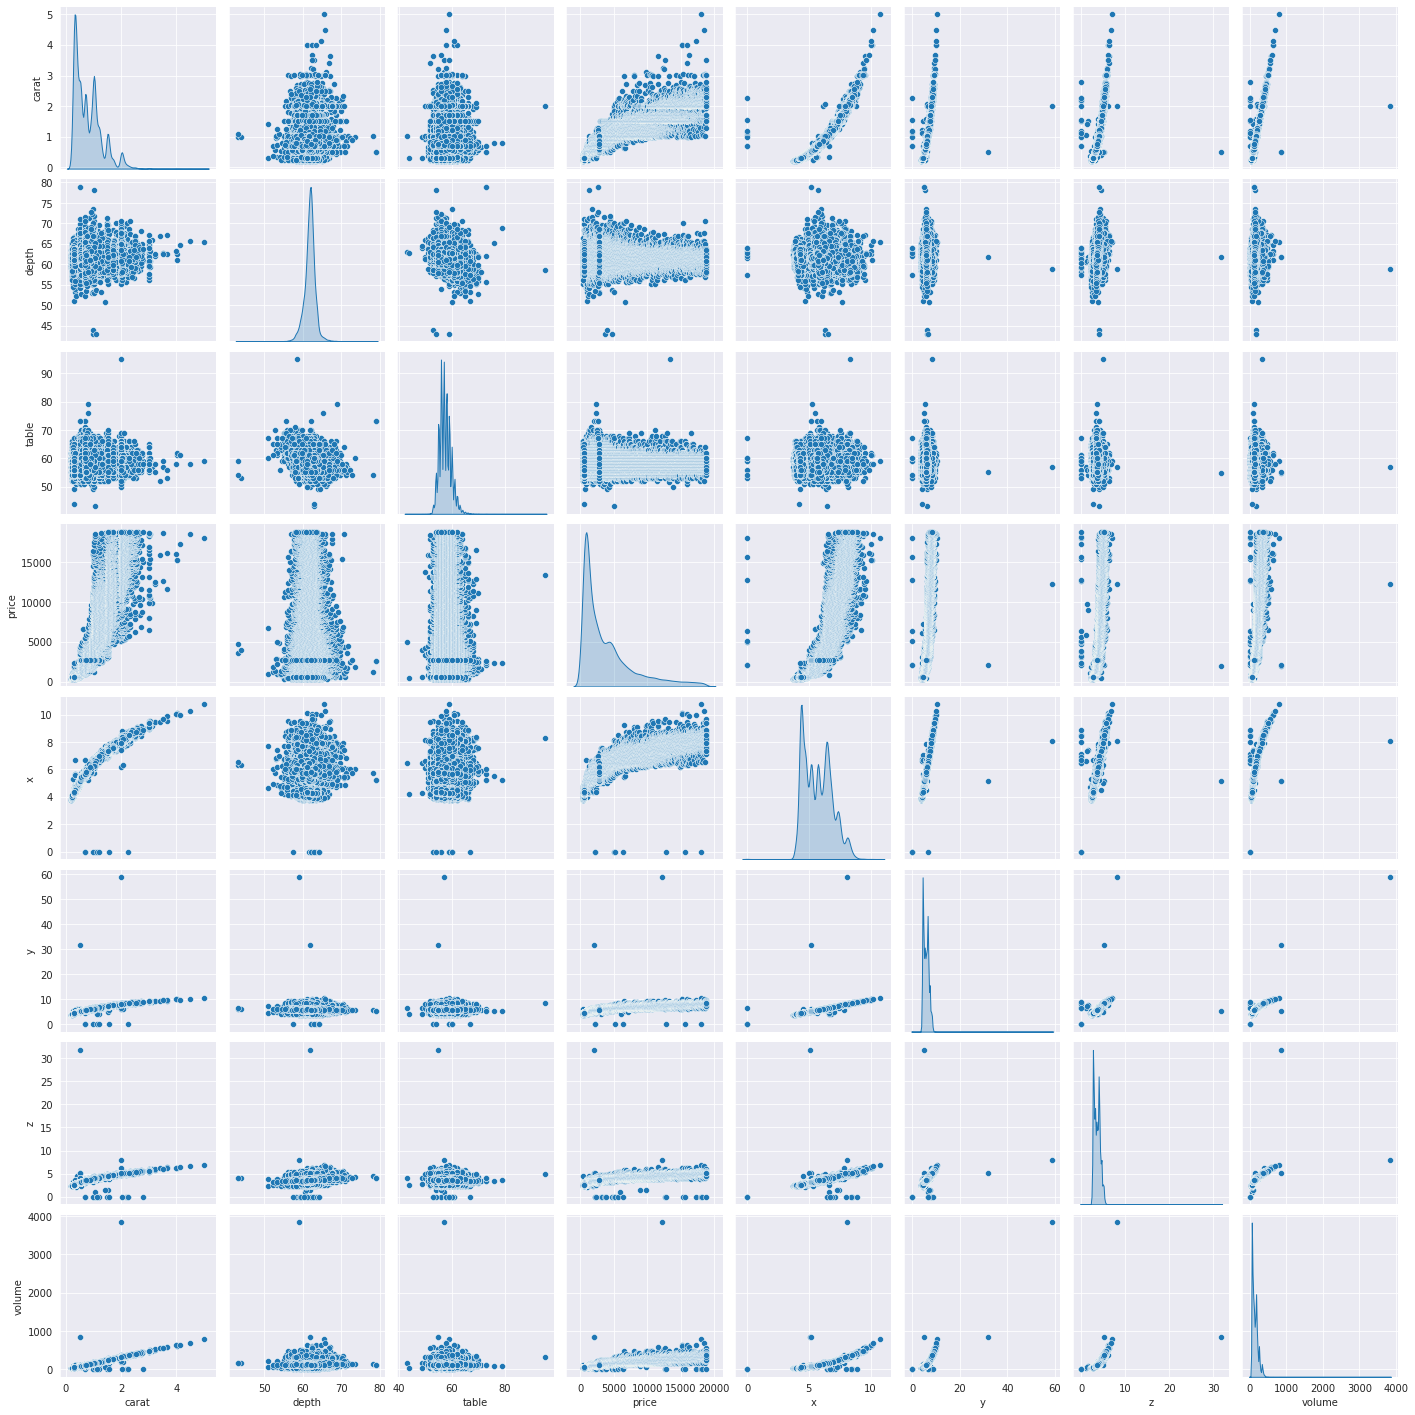

In [7]:
# Visualization of the linear relationships by pairwise plots
sns.pairplot(data , diag_kind = 'kde')

- Carat is measure by mass https://en.wikipedia.org/wiki/Carat_(mass)
- Since axis-y and axis-z has a very differnt pattern of axis-x, we cant tell that the shape of the dimonds is mostly determind by axis-x.
- The pattern of axis-x on carat is curve can confirm the reason by the formula for the volume of a sphere is V = 4/3 πr³
- We simply create a new column as **Volumn** by mutiply the axis-x,y,z as a measure of volume

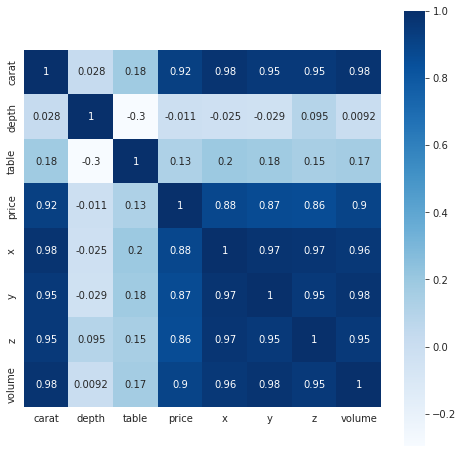

In [113]:
# Correlation between all variables
plt.figure(figsize=(8,8)) 
p=sns.heatmap(data.corr(), annot=True ,square=True, cmap="Blues") 

- We can see that carat is high correlated with price and the following ranking of the the correlation is volume, axis-x, axis-y, axis-z, table and depth.
- The individual measures of size (x, y, z) is considered stongly related to price.
- The depth percentage (depth) and table are considered low related to price.


### Transformation

In [99]:
from scipy.stats import norm, skew, boxcox

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


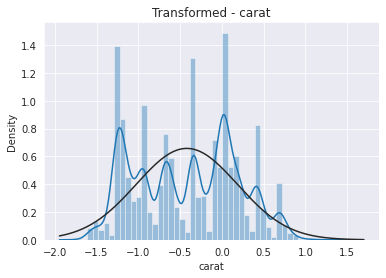

mu carat : -0.4192902706456786, sigma carat : 0.6063529992614062



In [125]:
data_trans = data
data_trans["carat"], best_lambda = boxcox(data_trans["carat"])

sns.distplot(data_trans["carat"], fit = norm)
plt.title('Transformed - carat')
plt.show()
(mu, sigma) = norm.fit(data_trans["carat"])
print("mu {} : {}, sigma {} : {}".format("carat", mu, "carat", sigma))
print()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


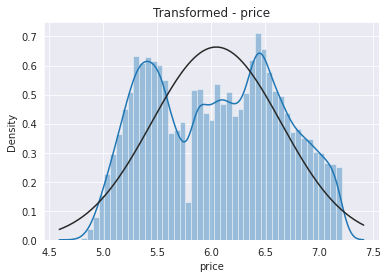

mu price : 6.04690401519193, sigma carat : 0.6010609495326986



In [126]:
data_trans["price"], best_lambda = boxcox(data_trans["price"])

sns.distplot(data_trans["price"], fit = norm)
plt.title('Transformed - price')
plt.show()
(mu, sigma) = norm.fit(data_trans["price"])
print("mu {} : {}, sigma {} : {}".format("price", mu, "carat", sigma))
print()

## Categorical Variables

<Figure size 864x432 with 0 Axes>

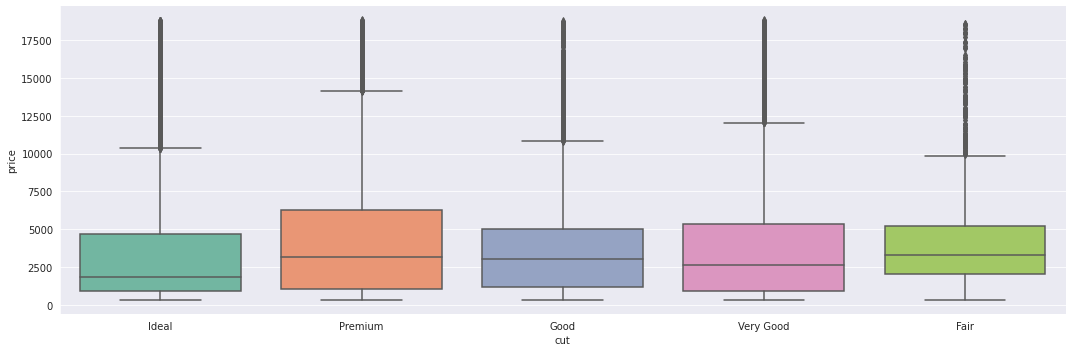

<Figure size 864x432 with 0 Axes>

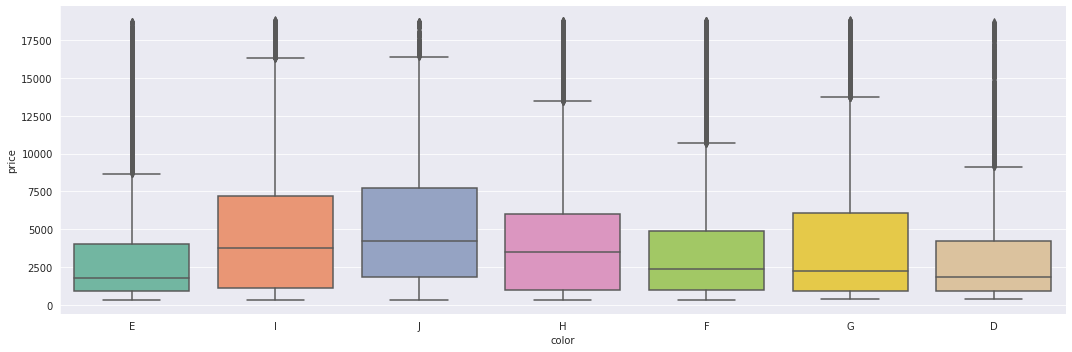

<Figure size 864x432 with 0 Axes>

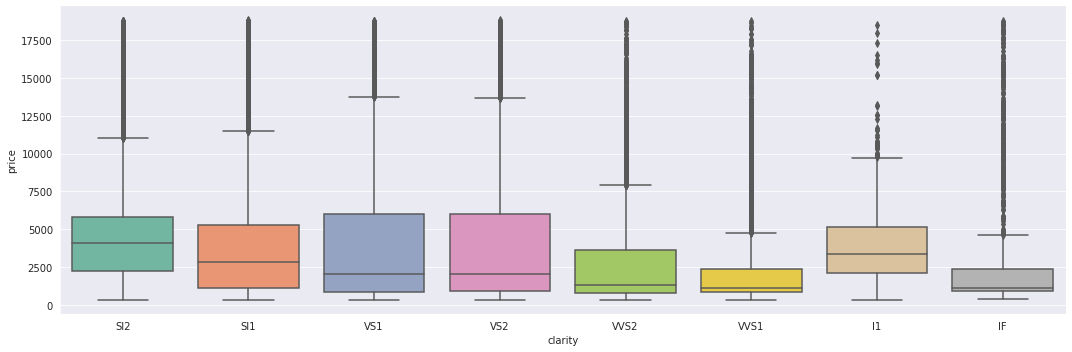

In [123]:
cat_columns = data.select_dtypes(include = ['object']).columns.tolist()

for col in cat_columns:
    plt.figure(figsize=(12,6))
    sns.catplot(x=col, y="price",kind="box", dodge=False, height = 5, aspect = 3,data=data, palette="Set2")

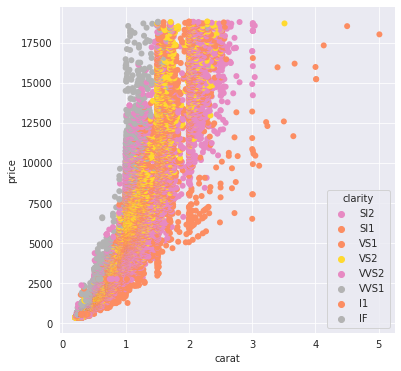

In [124]:
f, ax = plt.subplots(figsize=(6, 6))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x=data['carat'], y=data['price'],
                hue=data['clarity'], 
                palette="Set2",
                hue_order=data['clarity'],
                sizes=(1, 8), 
                linewidth=0,
                data=data, ax=ax)

### One-Hot Encoding
Forcing an ordinal relationship via an ordinal encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')
data_onehot = encoder.fit_transform(data)
print(data_onehot)

In [151]:
data_onehot = pd.get_dummies(data)
data_onehot.drop(columns=['volume'], inplace =True)
data_onehot.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [129]:
# Transformation Data
data_trans_onehot = pd.get_dummies(data_trans)
data_trans_onehot.drop(columns=['volume'], inplace =True)
data_trans_onehot.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.577105,61.5,55.0,4.797128,3.95,3.98,2.43,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,-1.682146,59.8,61.0,4.797128,3.89,3.84,2.31,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,-1.577105,56.9,65.0,4.799206,4.05,4.07,2.31,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,-1.313519,62.4,58.0,4.813567,4.20,4.23,2.63,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,-1.238751,63.3,58.0,4.815592,4.34,4.35,2.75,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


# Model - No Normalization

## Pytorch Model

### Pre-Training

#### Reshape Dataset

In [71]:
# convert the dataframes to arrages
def dataframe_to_arrays(df,input_cols, output_col):
    # Make a copy of the original dataframe
    df1 = df.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = df1[input_cols].to_numpy() #converting dataframes to numpy arrays
    targets_array = df1[output_col].to_numpy()
    return inputs_array, targets_array

# selected input cols to predict the diamond price
input_cols = data_onehot.columns.values.tolist() # Converting the dataframe columns to list
input_cols.remove('price')
input_cols.remove('depth')

# price is the target variable
output_col = ['price']

# split up the data into the regressors (inputs) and response variable (targets)
inputs_array, targets_array = dataframe_to_arrays(data_onehot, input_cols, output_col)

# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs_array, dtype=torch.float32), torch.tensor(targets_array, dtype=torch.float32))
print(dataset[:3])

(tensor([[ 0.2300, 55.0000,  3.9500,  3.9800,  2.4300,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.2100, 61.0000,  3.8900,  3.8400,  2.3100,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.2300, 65.0000,  4.0500,  4.0700,  2.3100,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000]]), tensor([[326.],
        [326.],
        [327.]]))


#### Data Spilting

In [72]:

test_percent = 0.2
batch_size = 16
torch.manual_seed(99)

# Split the data into a test and training set
test_size = int(inputs_array.shape[0] * test_percent)
train_size = inputs_array.shape[0] - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size*2)

# Look at a batch of data to verify everything is working
for xb, yb in train_loader:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([16, 25])
torch.Size([16, 1])


### Pytorch Linear Model Building

In [84]:
# Formulate a neural network

class LinearModel_DiamondPrice(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(len(input_cols), len(output_col))
        
    def forward(self, xb):
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [85]:
model = LinearModel_DiamondPrice()
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0094, -0.0482,  0.0857,  0.1187, -0.0143, -0.1582,  0.0968, -0.0700,
           0.1693,  0.1446,  0.0855, -0.1920,  0.0076, -0.0669, -0.0025,  0.1438,
          -0.0572,  0.0264, -0.0841,  0.1220, -0.1965,  0.0724,  0.1054, -0.1890,
           0.1185]], requires_grad=True), Parameter containing:
 tensor([-0.0290], requires_grad=True)]

In [86]:
def evaluate(model, test_loader):
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, test_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [87]:
result = evaluate(model, test_loader)
result

{'val_loss': 31121660.0}

In [88]:
epochs = 100
lr = 1e-4
history = fit(epochs, lr, model, train_loader, test_loader)

Epoch [1], val_loss: 3936141.7500
Epoch [2], val_loss: 3437479.0000
Epoch [3], val_loss: 3346270.0000
Epoch [4], val_loss: 3285303.2500
Epoch [5], val_loss: 3193993.0000
Epoch [6], val_loss: 3147761.5000
Epoch [7], val_loss: 3403485.5000
Epoch [8], val_loss: 3129899.5000
Epoch [9], val_loss: 3218644.7500
Epoch [10], val_loss: 3074246.2500
Epoch [11], val_loss: 3352415.0000
Epoch [12], val_loss: 3080762.7500
Epoch [13], val_loss: 2847358.5000
Epoch [14], val_loss: 2803710.2500
Epoch [15], val_loss: 3047863.7500
Epoch [16], val_loss: 2993161.7500
Epoch [17], val_loss: 2735911.2500
Epoch [18], val_loss: 2712192.7500
Epoch [19], val_loss: 2716525.2500
Epoch [20], val_loss: 2688983.7500
Epoch [21], val_loss: 2925303.2500
Epoch [22], val_loss: 2596163.5000
Epoch [23], val_loss: 2840819.7500
Epoch [24], val_loss: 2750482.0000
Epoch [25], val_loss: 2715016.0000
Epoch [26], val_loss: 2513663.5000
Epoch [27], val_loss: 2493242.5000
Epoch [28], val_loss: 2488183.0000
Epoch [29], val_loss: 2490065

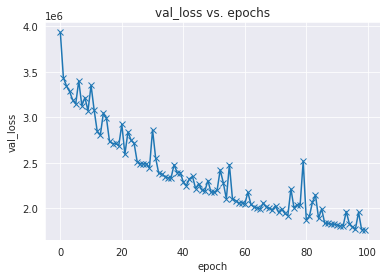

In [89]:
#losses = [r['val_loss'] for r in [result] + history]
losses = [r['val_loss'] for r in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

### Evaluate the Model

In [90]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()


In [91]:
x, target = test_ds[0]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 0.9000, 57.0000,  5.9600,  6.0100,  3.8900,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000])
Target:  3615.0
Prediction: 4537.66064453125


## Sklearn Mutilple Linear Regression

In [95]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

Training Shape: (43152, 26)
Testing Shape:  (10788, 26)
RMSE: 1091.56%
R2: 0.92


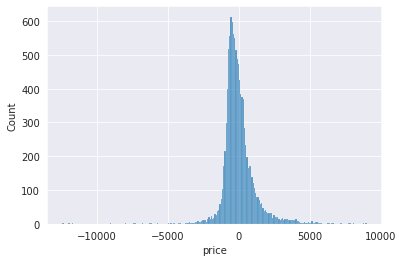

In [97]:
# divide into regressors and response
X = data_onehot.drop(columns = 'price')
y = data_onehot['price']

# Do 80/20 split for the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(f'Training Shape: {X_train.shape}')
print(f'Testing Shape:  {X_test.shape}')

# fit the model
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

# Get test predictions
y_pred = model.predict(X_test)

# evaluate the model

print("RMSE: {:.2f}%".format(mean_squared_error(y_test, y_pred, squared = False)))
print("R2: {:.2f}".format(r2_score(y_test, y_pred)))
errors = y_test - y_pred
sns.histplot(errors)

# # Model - Normalization

## Pytorch


In [140]:
# selected input cols to predict the diamond price
input_cols = data_trans_onehot.columns.values.tolist() # Converting the dataframe columns to list
input_cols.remove('price')
input_cols.remove('depth')

# price is the target variable
output_col = ['price']

# split up the data into the regressors (inputs) and response variable (targets)
inputs_array, targets_array = dataframe_to_arrays(data_trans_onehot, input_cols, output_col)

# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs_array, dtype=torch.float32), torch.tensor(targets_array, dtype=torch.float32))

# parameters
test_percent = 0.2
batch_size = 16
torch.manual_seed(99)

# Split the data into a test and training set
test_size = int(inputs_array.shape[0] * test_percent)
train_size = inputs_array.shape[0] - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size*2)

# Look at a batch of data to verify everything is working
for xb, yb in train_loader:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([16, 25])
torch.Size([16, 1])


In [141]:
model_trans = LinearModel_DiamondPrice()
list(model_trans.parameters())

[Parameter containing:
 tensor([[-0.0056, -0.1407, -0.1449, -0.0710, -0.0601,  0.0437, -0.0973, -0.0749,
           0.1058, -0.1113,  0.0553, -0.0008,  0.0139,  0.0471,  0.0570, -0.1907,
           0.0355,  0.1401, -0.1910,  0.1251,  0.0271, -0.1638, -0.0908,  0.0994,
           0.0109]], requires_grad=True), Parameter containing:
 tensor([0.0033], requires_grad=True)]

In [142]:
result = evaluate(model_trans, test_loader)
result

{'val_loss': 244.3385009765625}

In [143]:
epochs = 40
lr = 1e-4
history = fit(epochs, lr, model_trans, train_loader, test_loader)

Epoch [1], val_loss: 0.1068
Epoch [2], val_loss: 0.0736
Epoch [3], val_loss: 0.3826
Epoch [4], val_loss: 0.0568
Epoch [5], val_loss: 0.0519
Epoch [6], val_loss: 0.0483
Epoch [7], val_loss: 0.0473
Epoch [8], val_loss: 0.0440
Epoch [9], val_loss: 0.0411
Epoch [10], val_loss: 0.0420
Epoch [11], val_loss: 0.0380
Epoch [12], val_loss: 0.0370
Epoch [13], val_loss: 0.0361
Epoch [14], val_loss: 0.0352
Epoch [15], val_loss: 0.0367
Epoch [16], val_loss: 0.0344
Epoch [17], val_loss: 0.0334
Epoch [18], val_loss: 0.0331
Epoch [19], val_loss: 0.0327
Epoch [20], val_loss: 0.0317
Epoch [21], val_loss: 0.0313
Epoch [22], val_loss: 0.0310
Epoch [23], val_loss: 0.0321
Epoch [24], val_loss: 0.0308
Epoch [25], val_loss: 0.0314
Epoch [26], val_loss: 0.0308
Epoch [27], val_loss: 0.0313
Epoch [28], val_loss: 0.0297
Epoch [29], val_loss: 0.0289
Epoch [30], val_loss: 0.0317
Epoch [31], val_loss: 0.0286
Epoch [32], val_loss: 0.0290
Epoch [33], val_loss: 0.0282
Epoch [34], val_loss: 0.0279
Epoch [35], val_loss: 0

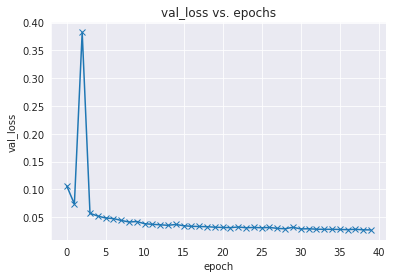

In [144]:
losses = [r['val_loss'] for r in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

In [146]:
x, target = test_ds[0]
pred = predict_single(x, model_trans)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([-0.1059, 57.0000,  5.9600,  6.0100,  3.8900,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000])
Target:  6.305110931396484
Prediction: 6.091983318328857


## Sklearn

Training Shape: (43152, 26)
Testing Shape:  (10788, 26)
RMSE: 0.08%
R2: 0.98


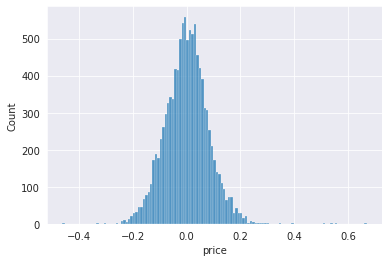

In [147]:
# divide into regressors and response
X = data_trans_onehot.drop(columns = 'price')
y = data_trans_onehot['price']

# Do 80/20 split for the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(f'Training Shape: {X_train.shape}')
print(f'Testing Shape:  {X_test.shape}')

# fit the model
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

# Get test predictions
y_pred = model.predict(X_test)

# evaluate the model

print("RMSE: {:.2f}%".format(mean_squared_error(y_test, y_pred, squared = False)))
print("R2: {:.2f}".format(r2_score(y_test, y_pred)))
errors = y_test - y_pred
sns.histplot(errors)

- **After transform the data, R2 score increase to 0.98 from 0.92, which is a amazing result.**

# Underfit vs Overfit

## Overfit

Training Shape: (53400, 26)
Testing Shape:  (540, 26)
RMSE: 971.38%
R2: 0.93


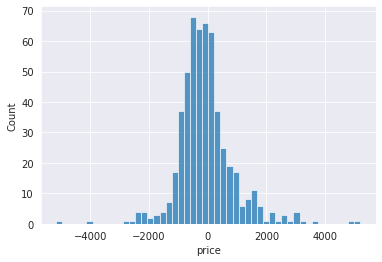

In [152]:
# divide into regressors and response
X = data_onehot.drop(columns = 'price')
y = data_onehot['price']

# Do 99/1 split for the train-test split for Overfit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01)
print(f'Training Shape: {X_train.shape}')
print(f'Testing Shape:  {X_test.shape}')

# fit the model
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

# Get test predictions
y_pred = model.predict(X_test)

# evaluate the model

print("RMSE: {:.2f}%".format(mean_squared_error(y_test, y_pred, squared = False)))
print("R2: {:.2f}".format(r2_score(y_test, y_pred)))
errors = y_test - y_pred
sns.histplot(errors)

## Underfit

Training Shape: (539, 26)
Testing Shape:  (53401, 26)
RMSE: 1130.48%
R2: 0.92


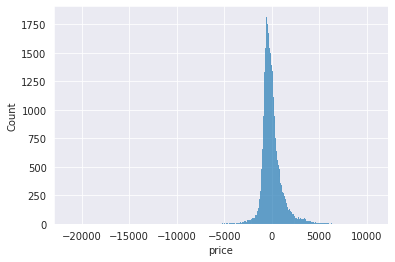

In [154]:
# divide into regressors and response
X = data_onehot.drop(columns = 'price')
y = data_onehot['price']

# Do 1/99 split for the train-test split for Overfit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.99)
print(f'Training Shape: {X_train.shape}')
print(f'Testing Shape:  {X_test.shape}')

# fit the model
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

# Get test predictions
y_pred = model.predict(X_test)

# evaluate the model

print("RMSE: {:.2f}%".format(mean_squared_error(y_test, y_pred, squared = False)))
print("R2: {:.2f}".format(r2_score(y_test, y_pred)))
errors = y_test - y_pred
sns.histplot(errors)